In [2]:
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import numpy as np
from torch.utils.data import DataLoader, Dataset
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import torchvision.transforms as T
from torch import nn, optim
from torchmetrics.classification import BinaryJaccardIndex
from tqdm import tqdm

In [3]:
DEVICE = 'cuda'
DEVICE

'cuda'

In [1]:
!pip install torchmetrics -qq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 57.0 MB/s eta 0:00:00


In [4]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("quadeer15sh/augmented-forest-segmentation")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'augmented-forest-segmentation' dataset.
Path to dataset files: /kaggle/input/augmented-forest-segmentation


In [5]:
class NewDataSet(Dataset):
    def __init__(self, csv_file, image_dir, mask_dir, img_transform, mask_transform):
        self.csv_file = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.img_transform = img_transform
        self.mask_transform = mask_transform


    def __len__(self):
        return len(self.csv_file)

    def __getitem__(self, idx):
        img_name = self.csv_file.iloc[idx]['image']
        mask_name = self.csv_file.iloc[idx]['mask']

        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, mask_name)

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")



        if self.img_transform:
            image = self.img_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
        else:
            mask = T.ToTensor()(mask)

        return image, mask


In [6]:
img_transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),
])

mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),
    T.ToTensor(),
    T.Lambda(lambda x: (x > 0.5).float())  # дополнительная страховка
])

In [8]:
dataset = NewDataSet(
    csv_file='/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/meta_data.csv',
    image_dir='/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/images',
    mask_dir='/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented/masks',
    img_transform=img_transform,
    mask_transform=mask_transform
)

In [9]:
train_dataset, valid_dataset = train_test_split(dataset)

In [10]:
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=8)
valid_loader = DataLoader(valid_dataset, shuffle=True, batch_size=8)


In [11]:
img, msk = next(iter(train_loader))


In [12]:
img.shape

torch.Size([8, 3, 256, 256])

In [13]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # encoder
        xe11 = relu(self.e11(x))
        xe12 = relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.e21(xp1))
        xe22 = relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.e31(xp2))
        xe32 = relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.e41(xp3))
        xe42 = relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.e51(xp4))
        xe52 = relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

    def fit(self, optimizer, criterion_msk, epochs, train_loader, valid_loader):
        iou_metric = BinaryJaccardIndex().to(DEVICE)
        log = dict()


        log['epoch_train_mask_loss'] = []
        log['epoch_valid_mask_loss'] = []

        log['epoch_train_iou'] = []
        log['epoch_valid_iou'] = []

        for epoch in range(epochs):
            progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=True)

            batch_mask_loss_train = []

            self.train()
            iou_metric.reset()
            for img, mask in  progress_bar:
                img = img.to(DEVICE)
                mask = mask.to(DEVICE)

                coords = self(img)

                loss_mask = criterion_msk(coords, mask)

                loss_mask.backward()
                optimizer.step()
                optimizer.zero_grad()

                iou_metric.update(coords, mask)


                batch_mask_loss_train.append(loss_mask.item())


            epoch_iou = iou_metric.compute().item()
            log['epoch_train_mask_loss'].append(np.mean(batch_mask_loss_train))
            log['epoch_train_iou'].append(epoch_iou)

            self.eval()
            iou_metric.reset()
            batch_mask_loss_valid = []
            for img, mask in valid_loader:
                img = img.to(DEVICE)
                mask = mask.to(DEVICE)

                with torch.inference_mode():
                    coords = self(img)

                loss_mask = criterion_msk(coords, mask)

                iou_metric.update(coords, mask)

                # accuracy = (logits.argmax(1) == labels.squeeze()).sum()/labels.size(0)


                batch_mask_loss_valid.append(loss_mask.item())

            epoch_iou_val = iou_metric.compute().item()
            log['epoch_valid_mask_loss'].append(np.mean(batch_mask_loss_valid))
            log['epoch_valid_iou'].append(epoch_iou_val)

            print(f"Epoch {epoch + 1} Train stage:  mask_loss: {log['epoch_train_mask_loss'][-1]:.3f}  iou: {log['epoch_train_iou'][-1]:.3f}")
            print(f"Epoch {epoch + 1} valid stage:  mask_loss: {log['epoch_valid_mask_loss'][-1]:.3f}  iou: {log['epoch_valid_iou'][-1]:.3f}")
        return log





In [14]:
model = UNet(1)
model.to(DEVICE)

UNet(
  (e11): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [15]:
optimizer = optim.Adam(model.parameters())
criterion_msk = nn.BCEWithLogitsLoss()

In [16]:
model.fit(optimizer, criterion_msk, 15, train_loader, valid_loader)

Epoch 1: 100%|██████████| 479/479 [03:15<00:00,  2.45it/s]


Epoch 1 Train stage:  mask_loss: 0.622  iou: 0.600
Epoch 1 valid stage:  mask_loss: 0.559  iou: 0.664


Epoch 2: 100%|██████████| 479/479 [03:21<00:00,  2.38it/s]


Epoch 2 Train stage:  mask_loss: 0.573  iou: 0.658
Epoch 2 valid stage:  mask_loss: 0.590  iou: 0.608


Epoch 3: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 3 Train stage:  mask_loss: 0.534  iou: 0.686
Epoch 3 valid stage:  mask_loss: 0.500  iou: 0.695


Epoch 4: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 4 Train stage:  mask_loss: 0.506  iou: 0.700
Epoch 4 valid stage:  mask_loss: 0.490  iou: 0.720


Epoch 5: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 5 Train stage:  mask_loss: 0.502  iou: 0.703
Epoch 5 valid stage:  mask_loss: 0.471  iou: 0.723


Epoch 6: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 6 Train stage:  mask_loss: 0.499  iou: 0.706
Epoch 6 valid stage:  mask_loss: 0.463  iou: 0.729


Epoch 7: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 7 Train stage:  mask_loss: 0.483  iou: 0.712
Epoch 7 valid stage:  mask_loss: 0.460  iou: 0.728


Epoch 8: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 8 Train stage:  mask_loss: 0.481  iou: 0.713
Epoch 8 valid stage:  mask_loss: 0.448  iou: 0.721


Epoch 9: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 9 Train stage:  mask_loss: 0.475  iou: 0.715
Epoch 9 valid stage:  mask_loss: 0.449  iou: 0.719


Epoch 10: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 10 Train stage:  mask_loss: 0.465  iou: 0.720
Epoch 10 valid stage:  mask_loss: 0.437  iou: 0.737


Epoch 11: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 11 Train stage:  mask_loss: 0.461  iou: 0.720
Epoch 11 valid stage:  mask_loss: 0.447  iou: 0.732


Epoch 12: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 12 Train stage:  mask_loss: 0.460  iou: 0.723
Epoch 12 valid stage:  mask_loss: 0.430  iou: 0.736


Epoch 13: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 13 Train stage:  mask_loss: 0.456  iou: 0.723
Epoch 13 valid stage:  mask_loss: 0.455  iou: 0.699


Epoch 14: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 14 Train stage:  mask_loss: 0.451  iou: 0.727
Epoch 14 valid stage:  mask_loss: 0.420  iou: 0.743


Epoch 15: 100%|██████████| 479/479 [03:20<00:00,  2.39it/s]


Epoch 15 Train stage:  mask_loss: 0.444  iou: 0.731
Epoch 15 valid stage:  mask_loss: 0.430  iou: 0.742


{'epoch_train_mask_loss': [np.float64(0.6217810102818156),
  np.float64(0.5732842696235673),
  np.float64(0.5339241266748352),
  np.float64(0.5056426278111332),
  np.float64(0.5023142577835314),
  np.float64(0.498687761499389),
  np.float64(0.48298077499941144),
  np.float64(0.4809473948961509),
  np.float64(0.47511246918636474),
  np.float64(0.46515810240783373),
  np.float64(0.4609730684495918),
  np.float64(0.45955229648593077),
  np.float64(0.4557578654839251),
  np.float64(0.451030884039178),
  np.float64(0.44377278709212525)],
 'epoch_valid_mask_loss': [np.float64(0.5588192572817207),
  np.float64(0.590229881927371),
  np.float64(0.5002525700256228),
  np.float64(0.48978416454046964),
  np.float64(0.47110704351216554),
  np.float64(0.4631410056725144),
  np.float64(0.4598182994872332),
  np.float64(0.44764956217259166),
  np.float64(0.4494904194958508),
  np.float64(0.43715314082801343),
  np.float64(0.4470027435570955),
  np.float64(0.4295841854065657),
  np.float64(0.4545748676

In [17]:
torch.save(model.state_dict(), "model.pth")

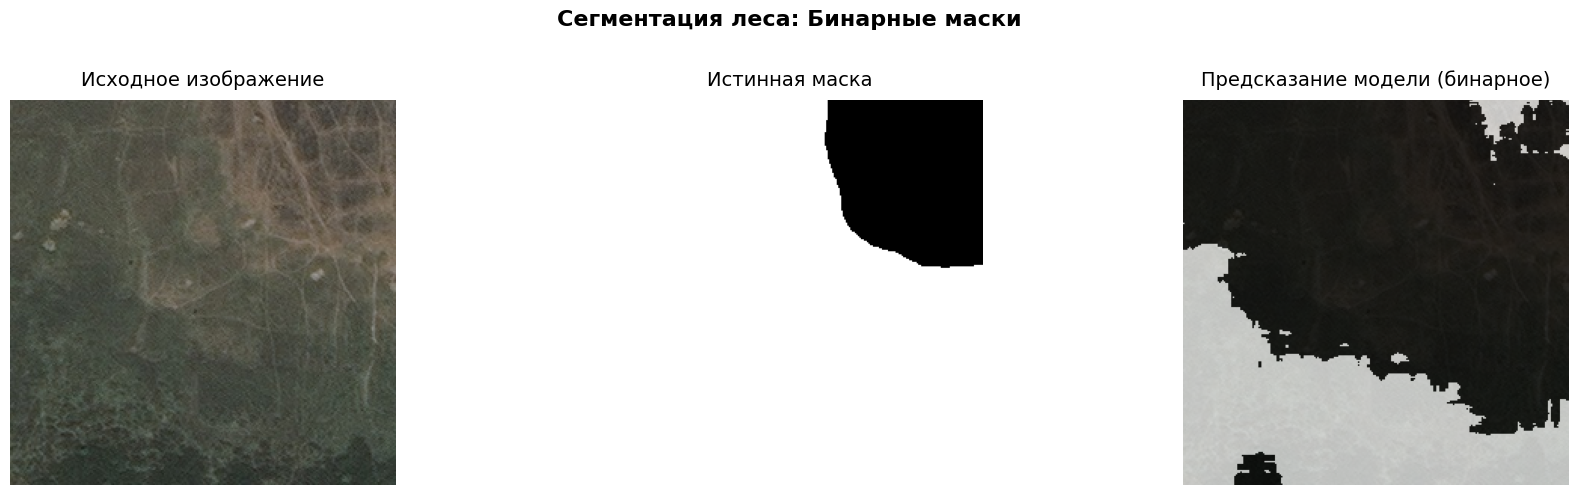

In [18]:
import matplotlib.pyplot as plt
import torch

# Получаем и обрабатываем данные
img_batch, mask_batch = next(iter(train_loader))
img_batch = img_batch.to(DEVICE)
with torch.no_grad():
    pred_logits = model(img_batch)
    pred_prob = torch.sigmoid(pred_logits)  # Логиты → вероятности

# Порог бинаризации (0.5 — стандарт для BCEWithLogitsLoss)
threshold = 0.5

# Берём первый пример и переносим на CPU
img = img_batch[0].cpu().permute(1, 2, 0)          # [H, W, C]
true_mask = mask_batch[0, 0].cpu()                # [H, W]
pred_mask_binary = (pred_prob[0, 0].cpu() > threshold).float()  # Бинарная маска [H, W]

# Создаём красивую визуализацию
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Сегментация леса: Бинарные маски', fontsize=16, fontweight='bold')

# 1. Исходное изображение
axes[0].imshow(img)
axes[0].set_title('Исходное изображение', fontsize=14, pad=10)
axes[0].axis('off')

# 2. Истинная маска (бинарная)
axes[1].imshow(true_mask, cmap='gray')
axes[1].set_title('Истинная маска', fontsize=14, pad=10)
axes[1].axis('off')

# 3. Предсказанная бинарная маска
axes[2].imshow(img)
axes[2].imshow(pred_mask_binary, cmap='gray', alpha=0.7, vmin=0, vmax=1)
axes[2].set_title('Предсказание модели (бинарное)', fontsize=14, pad=10)
axes[2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()